# M1. Actividad
#### Olivia Araceli Morales Quezada  A01707371

### Dado:
* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

### Realiza la siguiente simulación

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
  *  Si la celda está sucia, entonces aspira.
  * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

### Deberás recopilar la siguiente información durante la ejecución:

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. Desarrollar un informe con lo observado.

In [1]:
# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos estos paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import datetime, time

## Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Model, Agent

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid'' para manejar nuestro espacio.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''aleatoriamente''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector


### Get_Grid

In [2]:
MAXVAL = 10000

def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid

### Agent

In [3]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.agent_steps = 0
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.agent_steps += 1
                self.model.step_count += 1



### Model

In [4]:
class RobotVacuumCleanerModel (Model):
    def __init__(self, height, width, num_agents = 1, dirty_cells_percentage = 0.5, start=0.0):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(height, width, False)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (height, width) )
        self.step_count = 0
        self.start = start
        self.model_steps = 0
        self.height = height
        self.width = width
        
        # Ensuciamos el piso
        amount = int((width * height) * dirty_cells_percentage)
        print("Celdas sucias iniciales: ", amount)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
                    
        # Generamos los agentes
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        self.datacollector = DataCollector(model_reporters={"Grid":get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
    
    def percentage(self):
        clean_cells = int((self.width * self.height) -np.count_nonzero(self.floor == 1))
        clean_percentage = (clean_cells * 100) / (self.width * self.height)
        return clean_percentage
    
    def total_steps(self):
        total = self.step_count
        return total
    
    def execution_time(self):
        return round(time.time() - self.start, 3)*10
    
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()
        self.model_steps += 1
        

### Declaraciones iniciales

In [5]:
# Tamaño del Grid (n*m)
WIDTH = 20
HEIGHT = 20

# Número de agentes que limpiaran
NUM_AGENTS = 30

# Número de celdas iniciales a estar sucias
DIRTY_CELLS_PERCENTAGE = 0.5

# Tiempo de inicio
START = time.time()

# Máxinmo de iteraciones
MAX_ITERATIONS = 200

model = RobotVacuumCleanerModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_CELLS_PERCENTAGE, START)

i = 1
while i <= MAX_ITERATIONS and not model.is_all_clean():
    model.step()
    i += 1

    
    # Imprimimos el tiempo que le tomó correr al modelo.
print("No. agents: ", model.num_agents)
print("\nTotal de pasos dados por los agentes: ", model.total_steps())
print("\nPasos del modelo: ", model.model_steps)
    
for agent in model.schedule.agents:
    print ("Agente ", agent.unique_id, " dió ", agent.agent_steps, " pasos.")
    
print("\nPorcentaje de celdas limpias: ", (model.percentage()), "%.")
print('\nTiempo de ejecución: ', model.execution_time(), "segundos.")
print("***************************************************************************")


Celdas sucias iniciales:  200
No. agents:  30

Total de pasos dados por los agentes:  5176

Pasos del modelo:  200
Agente  0  dió  164  pasos.
Agente  1  dió  179  pasos.
Agente  2  dió  189  pasos.
Agente  3  dió  168  pasos.
Agente  4  dió  171  pasos.
Agente  5  dió  180  pasos.
Agente  6  dió  169  pasos.
Agente  7  dió  165  pasos.
Agente  8  dió  149  pasos.
Agente  9  dió  161  pasos.
Agente  10  dió  177  pasos.
Agente  11  dió  167  pasos.
Agente  12  dió  184  pasos.
Agente  13  dió  177  pasos.
Agente  14  dió  161  pasos.
Agente  15  dió  175  pasos.
Agente  16  dió  183  pasos.
Agente  17  dió  175  pasos.
Agente  18  dió  172  pasos.
Agente  19  dió  185  pasos.
Agente  20  dió  178  pasos.
Agente  21  dió  142  pasos.
Agente  22  dió  184  pasos.
Agente  23  dió  162  pasos.
Agente  24  dió  183  pasos.
Agente  25  dió  171  pasos.
Agente  26  dió  179  pasos.
Agente  27  dió  172  pasos.
Agente  28  dió  182  pasos.
Agente  29  dió  172  pasos.

Porcentaje de celdas lim

(array([1., 1., 0., 0., 5., 3., 5., 7., 6., 2.]),
 array([142. , 146.7, 151.4, 156.1, 160.8, 165.5, 170.2, 174.9, 179.6,
        184.3, 189. ]),
 <BarContainer object of 10 artists>)

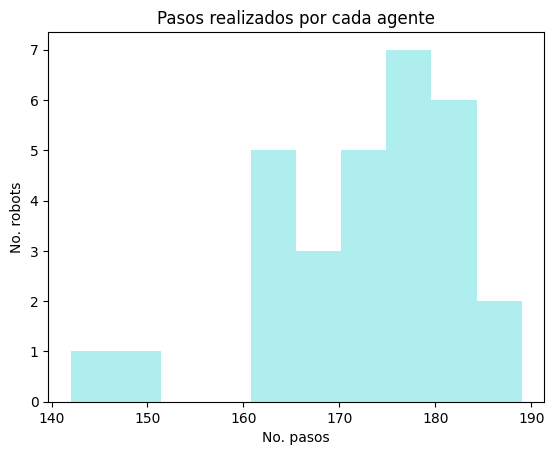

In [6]:

histogram = [agent.agent_steps for agent in model.schedule.agents]

plt.title('Pasos realizados por cada agente')
plt.xlabel('No. pasos')
plt.ylabel('No. robots')

plt.hist(histogram, color='paleturquoise')

In [7]:
all_grid = model.datacollector.get_model_vars_dataframe()
# print(all_grid)

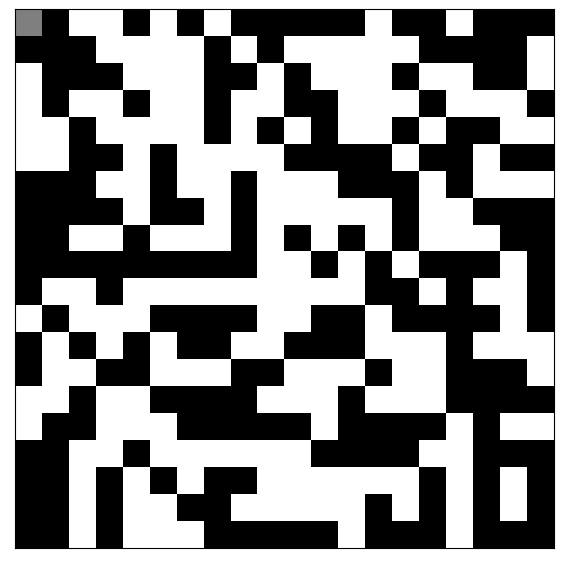

In [8]:
# Graficamos la información usando `matplotlib`

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)

In [9]:
anim